In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import dates as mpld
import matplotlib
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt


In [27]:
!pip3 lis

ModuleNotFoundError: No module named 'Last9_assignment'

In [2]:
class electricity_consumption:
    
    """Simulating electricity data"""

    def __init__(self):

        self.dates = []
        self.weekend = [5,6]
        self.summer_months = [4,5,6,7,8]
        self.summer_pers = np.arange(10,20)
        self.winter_pers = np.arange(8,18)

    def generateDates(self):

        dt = datetime.datetime(2019, 3, 15,18)
        end = datetime.datetime(2021, 3, 15,18)
        step = datetime.timedelta(hours=24)

        dates = []

        while dt < end:
            dates.append(dt.strftime('%Y-%m-%d %H:%M'))
            dt += step

        return dates

    def genratingData(self,initial_reading):

        dates = self.generateDates()
        consumption_dict = {}
        for date in dates:
            stripped = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M')
            day = stripped.weekday()
            month = stripped.month
            if month in self.summer_months:
                if day in self.weekend:
                    # Make each of the last 5 elements 5x more likely
                    prob = [1.0]*(len(self.summer_pers)-5) + [5.0]*5

                    # Normalising to 1.0
                    prob /= np.sum(prob)
                    day_consumption  = np.random.choice(self.summer_pers, p = prob)
                else:

                    day_consumption  = np.random.choice(self.summer_pers)
            else:
                if day in self.weekend:

                    # Make each of the last 5 elements 5x more likely
                    prob = [1.0]*(len(self.winter_pers)-5) + [5.0]*5

                    # Normalising to 1.0
                    prob /= np.sum(prob)
                    day_consumption  = np.random.choice(self.winter_pers, p = prob)

                else:

                    day_consumption  = np.random.choice(self.winter_pers)


            initial_reading += day_consumption


            consumption_dict[date] = initial_reading

        #Generating some laplace noise to add to the data
        noise = np.random.laplace(loc=0, scale=1, size=len(consumption_dict)) 

        df = pd.DataFrame(consumption_dict.items(), columns=['date', 'electricity_consumption'])
        df['electricity_consumption'] = df['electricity_consumption'] + noise


        return df


In [3]:
data = electricity_consumption()
df = data.genratingData(10)


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']


Seasonal Decompose of the time series
-------------------------------------
Seasonal decompose is a method used to decompose the components of a time series into the following:
- Level - average value in the series.
- Trend - increasing or decreasing value in the series.
- Seasonality - repeating short-term cycle in the series.
- Noise - random variation in the series.


## The analysis of the components individually provide better insights for model selection.


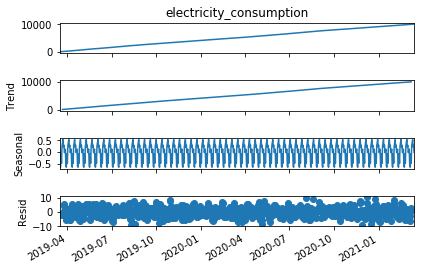

In [5]:
result_add = seasonal_decompose(
    df['electricity_consumption'], period=12, model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.rcParams["figure.figsize"]=(15, 8)


Observations from Seasonal Decompose
------------------------------------
1. The time series seems to roughly have a **constant seasonality** but has an overall **increasing trend**.

Model Selection
---------------
From the above observations we can evidently conclude that **Holt-Winter additive model** would 
be an appropriate choice as there is a constant seasonality component along with an increasing trend.

In [6]:
del df['date']

# Parameters for models
1. The seasonal decompose shows a additive seasonality as well as an increasing trend
2. The damping slope is set to 1 as we don't want to damp the trend of our predictions
3. The data has a seasonality of 12 so the periods have been choosen as 12


In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df, trend='additive',
                             seasonal='additive', seasonal_periods=12).fit(damping_slope= 1)

/home/utkarsh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:163: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [8]:
predictions = pd.DataFrame(model.forecast(14), columns = ['electricity_consumption'])

## Forecasting of electricity consumption from 15th March to 28th March of 2021

In [9]:
predictions

,electricity_consumption
2021-03-15 18:00:00,10049.598841
2021-03-16 18:00:00,10062.388447
2021-03-17 18:00:00,10074.465563
2021-03-18 18:00:00,10087.166331
2021-03-19 18:00:00,10100.368067
2021-03-20 18:00:00,10112.704248
2021-03-21 18:00:00,10126.067244
2021-03-22 18:00:00,10139.028556
2021-03-23 18:00:00,10151.845469
2021-03-24 18:00:00,10164.159012


In [10]:
# GAMMA = model.params['smoothing_seasonal']

In [11]:
"""Brutlag Algorithm"""
PERIOD = 12        # The given time series has seasonal_period=12
SF = 1.96          # brutlag scaling factor for the confidence bands. Decide the bandwith of the Upperbound and lower bound
GAMMA = 0.3684211
UB = []            # upper bound or upper confidence band
LB = []            # lower bound or lower confidence band

## Fitting a exponential smoothing model for Brut lag algorithm.

In [12]:

model = ExponentialSmoothing(
    df, trend='additive', seasonal='additive').fit()
prediction_all = model.predict(
    start=df.iloc[:, 0].index[0], end=df.iloc[:, 0].index[-1])


/home/utkarsh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:163: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/utkarsh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:725: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [13]:
difference_array = []
dt = []
difference_table = {
    "actual": df.iloc[:, 0], "predicted": prediction_all, "difference": difference_array, "UB": UB, "LB": LB}


## Calculating the Upper bound and lower bound for the entire series

In [14]:
"""Calculatation of confidence bands using brutlag algorithm"""
for i in range(len(prediction_all)):
    diff = df.iloc[:, 0][i]-prediction_all[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-PERIOD])

    difference_array.append(diff)
    UB.append(prediction_all[i]+SF*dt[i])
    LB.append(prediction_all[i]-SF*dt[i])

print("\nDifference between actual and predicted\n")
difference = pd.DataFrame(difference_table)
print(difference.head(2))


Difference between actual and predicted

                       actual  predicted  difference         UB         LB
2019-03-15 18:00:00  24.71198  27.992895   -3.280916  30.362062  25.623729
2019-03-16 18:00:00  42.44096  39.362707    3.078253  41.585530  37.139884


## Predicting the Upper bound and lower bound for the future dates

In [15]:
model_ub = ExponentialSmoothing(
    difference.iloc[:, 3], trend='additive', seasonal='additive').fit()
model_lb = ExponentialSmoothing(
    difference.iloc[:, 4], trend='additive', seasonal='additive').fit()

/home/utkarsh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:163: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/utkarsh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:163: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [16]:
predict_ub = model_ub.forecast(14)

In [17]:
predict_lb = model_lb.forecast(14)

In [18]:
UB.extend(predict_ub)

In [19]:
LB.extend(predict_lb)

In [20]:
df_3 = pd.concat([df, predictions])

In [21]:
normal = []
normal_date = []
anomaly = []
anomaly_date = []

## Comparing all the points with upper bound and lower bound and if the point does not lie in the band, then the point is an anamoly

In [22]:
for i in range(len(df_3.iloc[:, 0].index)):
    if (UB[i] <= df_3.iloc[:, 0][i] or LB[i] >= df_3.iloc[:, 0][i]) and i > PERIOD:
        anomaly_date.append(df_3.iloc[:, 0].index[i])
        anomaly.append(df_3.iloc[:, 0][i])
        
    else:
        normal_date.append(df_3.iloc[:, 0].index[i])
        normal.append(df_3.iloc[:, 0][i])


In [23]:

anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

## There is one point that have been flagged as anomaly by the brut lag algorithm

In [24]:
anomaly[anomaly.index >= '2021-03-15']

,value
date,
2021-03-28 18:00:00,10214.946649
